In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import numpy as np
import scipy.stats as sps
from scipy.constants import golden_ratio

import json, pickle, os, corner, glob, sys
from collections import defaultdict, OrderedDict
from copy import deepcopy
import pandas as pd
from astropy.time import Time
import astropy.units as u
from tqdm import tqdm
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Do not have mpi4py package.


In [3]:
color_cycle_wong = ['#000000','#E69F00','#009E73','#56B4E9','#0072B2','#F0E442','#D55E00','#CC79A7']
Six_color_cycle = ["#5790FC", "#F89C20", "#E42536", "#964A8B", "#9C9CA1", "#7A21DD"]
Eight_color_cycle = ["#1845FB", "#FF5E02", "#C91F16", "#C849A9", "#ADAD7D", "#86C8DD", "#578DFF", "#656364"]
Ten_color_cycle = ["#3F90DA", "#FFA90E", "#BD1F01", "#94A4A2", "#832DB6", "#A96B59", "#E76300", "#B9AC70", "#717581", "#92DADD"]
mpl.rcParams['axes.prop_cycle'] = cycler(color=Eight_color_cycle)
def get_fig_size(width=15,scale=1.):
    #width = 3.36 # 242 pt
    base_size = np.array([1, 1/scale/golden_ratio])
    fig_size = width * base_size
    return(fig_size)
mpl.rcParams['figure.figsize'] = get_fig_size()
mpl.rcParams['text.usetex'] = False
mpl.rc('font',**{'family':'serif','serif':['Times New Roman']})
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
#mpl.rcParams["figure.dpi"] = 300

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
#top_path_idx = splt_path.index("akaiser")
top_path_idx = splt_path.index("nanograv")
top_dir = "/".join(splt_path[0 : top_path_idx + 1])

In [5]:
la_f_path = top_dir + "/la_forge"
e_e_path = top_dir + "/enterprise_extensions/"
sys.path.insert(0, la_f_path)
sys.path.insert(0, e_e_path)
sys.path.insert(0, top_dir + "/enterprise_timing")

In [6]:
import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import utils
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import signal_base
from enterprise.signals import selections

import enterprise_extensions as e_e
from enterprise_extensions import sampler
from enterprise_extensions import models
from enterprise_extensions.sampler import JumpProposal
from enterprise_extensions.timing import timing_block
from enterprise_extensions.blocks import channelized_backends

In [7]:
import la_forge
import la_forge.diagnostics as dg
from la_forge.core import TimingCore
from la_forge.core import Core

import nltm_plot_utils_v4 as nltm_plt
from nltm_setup_adv_noise_pta_v1 import pta_setup
from hypermodel_timing import TimingHyperModel

In [8]:
psr_name = 'J0740+6620'#'J0340+4130'#'J1640+2224'#'J2043+1711'#'J2317+1439' 'J1909-3744'
dataset='12p5yr'
parfile = top_dir + f"/enterprise_timing/J0740+6620_12yV3_dmgp.par"
timfile = top_dir + f"/{dataset}/narrowband/tim/{psr_name}_NANOGrav_12yv3.tim"
outdir = top_dir + f"/enterprise_timing/{psr_name}/chains/{dataset}/{psr_name}_jp_testing_1/"

ephem = 'DE438'

In [9]:
psr = Pulsar(parfile, timfile, ephem=ephem, clk=None, drop_t2pulsar=False)

In [10]:
supermodel = pta_setup(psr,"12p5yr",psr_name,
                tm_var=True,red_var=False,
                white_var=True,fit_remaining_pars=True,
                lin_dmx_jump_fd=False,
                tm_linear=False,
                incTimingModel=True,
                Ecorr_gp_basis=False,
                )

USING REFIT DM1. Val:  0.0001745623252178366 Err:  1.3670863977778197e-05
USING REFIT DM2. Val:  0.00017963800442828297 Err:  2.7968423589843706e-05
{'DM1': {'prior_lower_bound': -0.006660869663671262, 'prior_upper_bound': 0.007009994314106935}, 'DM2': {'prior_lower_bound': -0.01380457379049357, 'prior_upper_bound': 0.014163849799350137}}
Non-linearly varying these values:  ['ELONG', 'ELAT', 'F0', 'F1', 'DM1', 'DM2', 'PMELONG', 'PMELAT', 'PX', 'COSI', 'PB', 'A1', 'TASC', 'EPS1', 'EPS2', 'M2', 'FD1', 'JUMP1'] 
 in pulsar  J0740+6620
Linearly varying these values:  ['Offset']
Using  uniform  prior.
COSI added to tm_params_orig for to work with tm_delay.
COSI added to tm_params_orig for to work with tm_delay.
COSI added to tm_params_orig for to work with tm_delay.
COSI added to tm_params_orig for to work with tm_delay.
COSI added to tm_params_orig for to work with tm_delay.

{'0': {'dm_var': False, 'dm_nondiag_kernel': 'None', 'dm_sw_gp': False}, '1': {'dm_var': True, 'dm_nondiag_kernel':

In [18]:
group_names_1 = []
for grp in supermodel.get_parameter_groups_2():
    if not isinstance(grp,(int,np.int64)):
        group_names_1.append([supermodel.param_names[subgrp] for subgrp in grp])
    else:
        group_names_1.append(supermodel.param_names[grp])
group_names_2 = []
for p in supermodel.models.values():
    for grp in sampler.get_parameter_groups(p):
        if not isinstance(grp,(int,np.int64)):
            group_names_2.append([p.param_names[subgrp] for subgrp in grp])
        else:
            group_names_2.append(p.param_names[grp])
list(np.unique(group_names_2))
group_names_2.extend([[supermodel.param_names[len(supermodel.param_names) - 1]]])  # nmodel

In [27]:
grp_dict = defaultdict(list)
for grp1,grp2 in zip(group_names_1,group_names_2):
    if not isinstance(grp1,(int,np.int64)):
        for subgroup1,subgroup2 in zip(grp1,grp2):
            grp_dict['group_1'].append(subgroup1)
            grp_dict['group_2'].append(subgroup2)
            print(subgroup1,subgroup2)
    else:
        grp_dict['group_1'].append(grp1)
        grp_dict['group_2'].append(grp2)
        print(grp1,grp2)
    grp_dict['group_1'].append('-')
    grp_dict['group_2'].append('-')
    print('------------')

J0740+6620_Rcvr1_2_GUPPI_efac J0740+6620_Rcvr1_2_GUPPI_efac
J0740+6620_Rcvr1_2_GUPPI_log10_ecorr J0740+6620_Rcvr1_2_GUPPI_log10_ecorr
J0740+6620_Rcvr1_2_GUPPI_log10_equad J0740+6620_Rcvr1_2_GUPPI_log10_equad
J0740+6620_Rcvr_800_GUPPI_efac J0740+6620_Rcvr_800_GUPPI_efac
J0740+6620_Rcvr_800_GUPPI_log10_ecorr J0740+6620_Rcvr_800_GUPPI_log10_ecorr
J0740+6620_Rcvr_800_GUPPI_log10_equad J0740+6620_Rcvr_800_GUPPI_log10_equad
J0740+6620_timing_model_A1 J0740+6620_timing_model_A1
J0740+6620_timing_model_COSI J0740+6620_timing_model_COSI
J0740+6620_timing_model_DM1 J0740+6620_timing_model_DM1
J0740+6620_timing_model_DM2 J0740+6620_timing_model_DM2
J0740+6620_timing_model_ELAT J0740+6620_timing_model_ELAT
J0740+6620_timing_model_ELONG J0740+6620_timing_model_ELONG
J0740+6620_timing_model_EPS1 J0740+6620_timing_model_EPS1
J0740+6620_timing_model_EPS2 J0740+6620_timing_model_EPS2
J0740+6620_timing_model_F0 J0740+6620_timing_model_F0
J0740+6620_timing_model_F1 J0740+6620_timing_model_F1
J0740+6620_t

In [34]:
pd.set_option('max_rows', None)
df = pd.read_csv(top_dir+"/enterprise_timing/group_comp.csv",usecols=[1,2])
df

,group_from_hypermodel_param_names,group_from_model_param_names
0,J2043+1711_430_ASP_efac,J2043+1711_430_ASP_efac
1,J2043+1711_430_ASP_log10_ecorr,J2043+1711_430_ASP_log10_ecorr
2,J2043+1711_430_ASP_log10_equad,J2043+1711_430_ASP_log10_equad
3,J2043+1711_430_PUPPI_efac,J2043+1711_430_PUPPI_efac
4,J2043+1711_430_PUPPI_log10_ecorr,J2043+1711_430_PUPPI_log10_ecorr
5,J2043+1711_430_PUPPI_log10_equad,J2043+1711_430_PUPPI_log10_equad
6,J2043+1711_L-wide_ASP_efac,J2043+1711_L-wide_ASP_efac
7,J2043+1711_L-wide_ASP_log10_ecorr,J2043+1711_L-wide_ASP_log10_ecorr
8,J2043+1711_L-wide_ASP_log10_equad,J2043+1711_L-wide_ASP_log10_equad
9,J2043+1711_L-wide_PUPPI_efac,J2043+1711_L-wide_PUPPI_efac


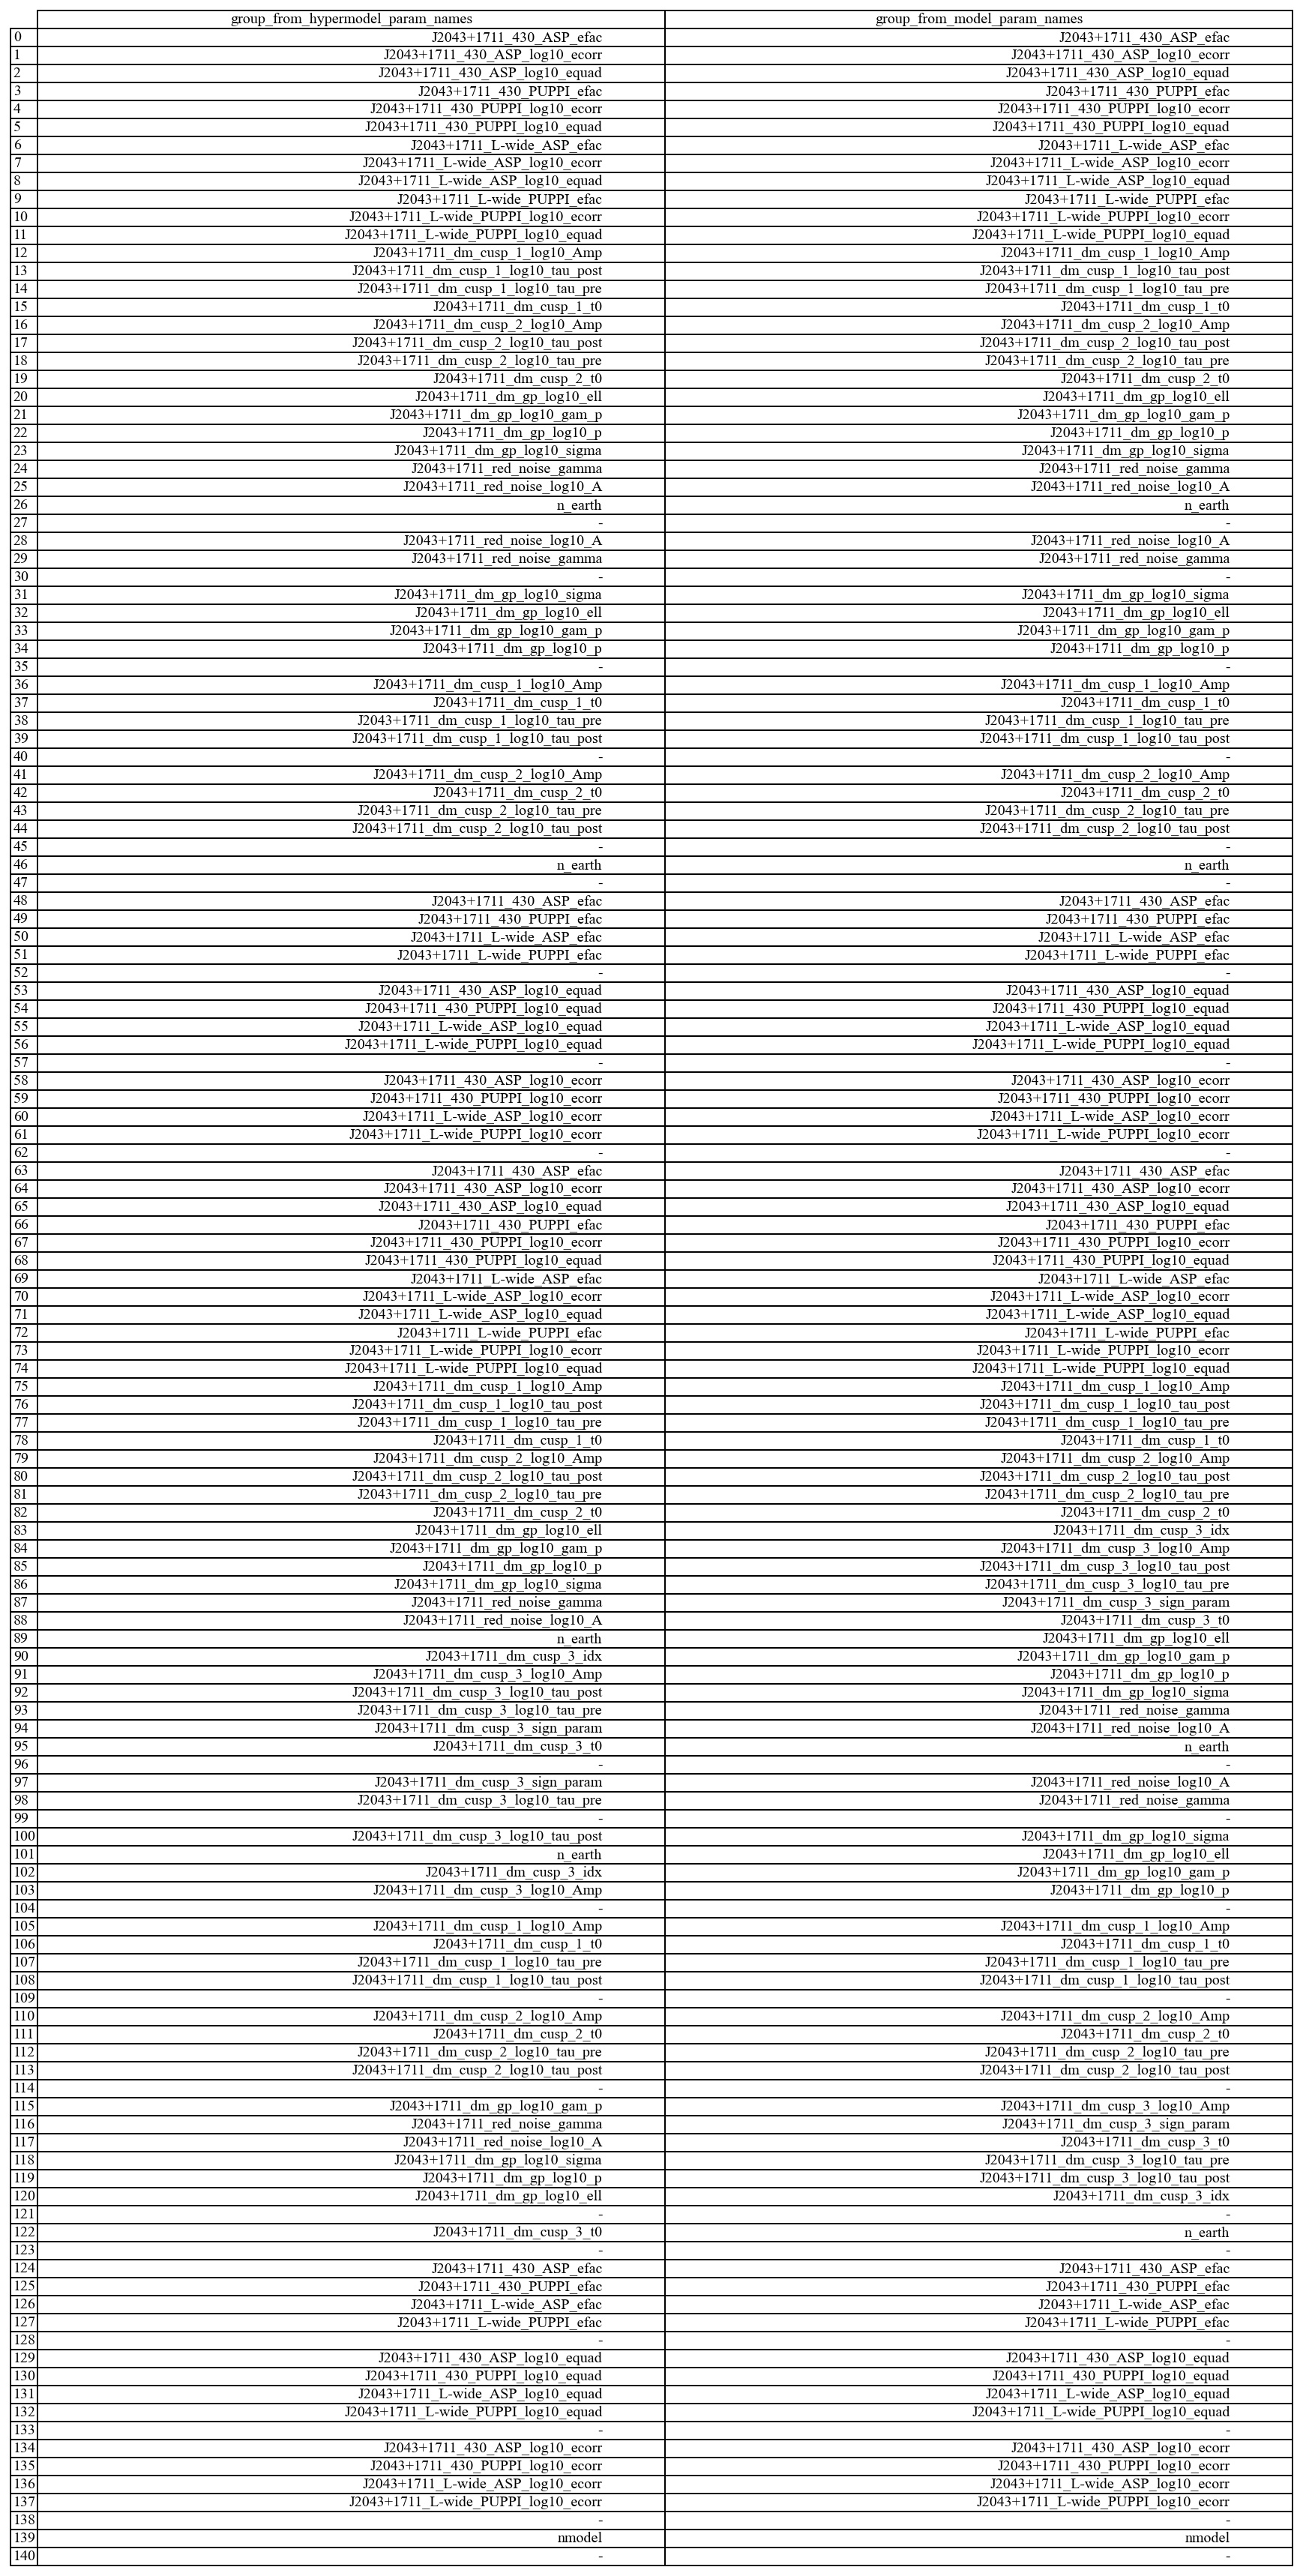

In [42]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

pd.plotting.table(ax, df,loc='center')  # where df is your data frame
#plt.subplot_adjust()
#plt.savefig('mytable.png')

In [ ]:
asdfasedf

In [ ]:
mysampler = supermodel.setup_sampler(resume = False, outdir = outdir)

In [ ]:
mysampler_num_iters = int(1e3)
mysampler_tm_draws = defaultdict(list)
mysampler_tm_prior_draws = defaultdict(list)
x0 = supermodel.initial_sample(tm_params_orig=psr.tm_params_orig,zero_start=True)
for iters in tqdm(range(mysampler_num_iters)):
    for pcyc in mysampler.propCycle:
        if pcyc.__name__ == 'draw_from_timing_model':
            q,qxy = pcyc(x0, 0, 1.)
            for i,draw in enumerate((q-x0)):
                if draw != 0.:
                    mysampler_tm_draws[supermodel.param_names[i]].append(q[i])
        elif pcyc.__name__ == 'draw_from_timing_model_prior':
            q,qxy = pcyc(x0, 0, 1.)
            for i,draw in enumerate((q-x0)):
                if draw != 0.:
                    mysampler_tm_prior_draws[supermodel.param_names[i]].append(q[i])

In [ ]:
# find model index variable
idx = list(supermodel.param_names).index("nmodel")
nmodel = int(np.rint(x0[idx]))

# find parameters of active model
q = []
for par in supermodel.models[nmodel].param_names:
    idx = supermodel.param_names.index(par)
    q.append(x0[idx])
q

In [ ]:
fig,ax = plt.subplots(len(mysampler_tm_draws.keys()),1,figsize=get_fig_size(scale=.25))
for i,(key,vals) in enumerate(mysampler_tm_draws.items()):
    ax[i].hist(vals,color=f'C{i}',histtype='step',linewidth=3.,density=True)
    ax[i].set_title(key)
fig.subplots_adjust(hspace=.6)
plt.show()

In [ ]:
for grp in mysampler.groups:
    if not isinstance(grp,(int,np.int64)):
        for subgrp in grp:
            print(supermodel.param_names[subgrp])
    else:
        print(supermodel.param_names[grp])
    print('------------')

In [ ]:
# dimension of parameter space
ndim = len(supermodel.param_names)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1 ** 2)

# parameter groupings
groups = supermodel.get_parameter_groups()
groups
#print(supermodel.get_timing_groups())
#groups.extend(sampler.get_timing_groups(supermodel))

psampler = ptmcmc(
    ndim,
    supermodel.get_lnlikelihood,
    supermodel.get_lnprior,
    cov,
    groups=groups,
    outDir=outdir,
    resume=False,
)

# additional jump proposals
jp = JumpProposal(supermodel, supermodel.snames, empirical_distr=None, timing=True)
psampler.jp = jp

# always add draw from prior
psampler.addProposalToCycle(jp.draw_from_prior, 1)

# Red noise prior draw
if "red noise" in jp.snames:
    print("Adding red noise prior draws...\n")
    psampler.addProposalToCycle(jp.draw_from_red_prior, 1)

# Non Linear Timing Draws
if "timing_model" in jp.snames:
    print("Adding timing model jump proposal...\n")
    psampler.addProposalToCycle(jp.draw_from_timing_model, 1)
if "timing_model" in jp.snames:
    print("Adding timing model prior draw...\n")
    psampler.addProposalToCycle(jp.draw_from_timing_model_prior, 1)
    
# White Noise Draws
if "timing_model" in jp.snames and any("ecorr" in x for x in jp.snames.keys()):
    print("Adding ECORR + timing model jump proposal...\n")
    #psampler.addProposalToCycle(jp.draw_from_ecorr_and_timing_model, 1)

In [ ]:
[x for x in jp.snames.keys()]

In [ ]:
supermodel.param_names

In [ ]:
sampler.get_timing_groups(supermodel)

In [ ]:
for model in supermodel.models.values():
    print(sampler.get_timing_groups(model))

In [ ]:
[x for x in supermodel.param_names if any(y in x for y in ["timing_model","ecorr"])]

In [ ]:
any("ecorr" in x for x in supermodel.param_names)

In [ ]:
sampler.group_from_params(supermodel, [x for x in supermodel.param_names if any(y in x for y in ["timing_model","ecorr"])])

In [ ]:
# parameter groupings
groups = supermodel.get_parameter_groups()
#groups.extend(supermodel.get_timing_groups())
#groups.append(sampler.group_from_params(supermodel,
#                                        [x for x in supermodel.param_names if any(y in x for y in ["timing_model","ecorr"])]))
for grp in groups:
    if not isinstance(grp,(int,np.int64)):
        for subgrp in grp:
            print(psampler.jp.pnames[subgrp])
    else:
        print(psampler.jp.pnames[grp])
    print('------------')

In [ ]:
# pickled_supermodel = cloudpickle.dumps(supermodel)
print(psampler.jp.tm_groups)
for grp in psampler.jp.tm_groups:
    if not isinstance(grp,np.int64):
        for subgrp in grp:
            print(psampler.jp.pnames[subgrp])
    else:
        print(psampler.jp.pnames[grp])
    print('------------')
print(psampler.jp.special_idxs)
print(len(psampler.propCycle))

In [ ]:
zero_start=True
if zero_start:
    x0 = []
    for p in supermodel.models[0].params:
        if "timing" in p.name:
            if "DMX" in p.name:
                p_name = ("_").join(p.name.split("_")[-2:])
            else:
                p_name = p.name.split("_")[-1]
            if psr.tm_params_orig[p_name][-1] == "normalized":
                x0.append([np.double(0.0)])
            else:
                x0.append([np.double(psr.tm_params_orig[p_name][0])])
        else:
            x0.append(np.array(p.sample()).ravel().tolist())
else:
    x0 = [np.array(p.sample()).ravel().tolist() for p in supermodel.models[0].params]
uniq_params = [str(p) for p in supermodel.models[0].params]
for model in supermodel.models.values():
    param_diffs = np.setdiff1d([str(p) for p in model.params], uniq_params)
    mask = np.array([str(p) in param_diffs for p in model.params])
    x0.extend(
        [
            np.array(pp.sample()).ravel().tolist()
            for pp in np.array(model.params)[mask]
        ]
    )
    uniq_params = np.union1d([str(p) for p in model.params], uniq_params)
x0.extend([[0.1]])
x0 = np.array([p for sublist in x0 for p in sublist])
x0

In [ ]:
supermodel.params[-2].sample()

In [ ]:
for pcyc in psampler.propCycle:
    print(pcyc.__name__)
    q,qxy = pcyc(x0, 0, 1.)
    print(q)
    print('change')
    print(q-x0)
    print('---------------')
    print('---------------')
    print('')

In [ ]:
num_iters = int(1e5)
tm_draws = defaultdict(list)
tm_prior_draws = defaultdict(list)
for iters in range(num_iters):
    for pcyc in psampler.propCycle:
        if pcyc.__name__ == 'draw_from_timing_model':
            q,qxy = pcyc(x0, 0, 1.)
            for i,draw in enumerate((q-x0)):
                if draw != 0.:
                    tm_draws[supermodel.param_names[i]].append(q[i])
        elif pcyc.__name__ == 'draw_from_timing_model_prior':
            q,qxy = pcyc(x0, 0, 1.)
            for i,draw in enumerate((q-x0)):
                if draw != 0.:
                    tm_prior_draws[supermodel.param_names[i]].append(q[i])

In [ ]:
supermodel.params

In [ ]:
print(str(supermodel.params[-1]))

In [ ]:
special_pars = []
for x in [str(y) for y in supermodel.params if "Uniform" in str(y) and "timing_model" in str(y)]:
    pmin = float(x.split('Uniform')[-1].split('pmin=')[1].split(',')[0])
    pmax = float(x.split('Uniform')[-1].split('pmax=')[-1].split(')')[0])
    if pmin+pmax != 0.0:
        special_pars.append(x.split(':')[0])
special_pars

In [ ]:
#special_pars = ["PX", "SINI", "COSI", "ECC"]
[ii for par, ii in jp.pimap.items() if np.any([sp in par for sp in special_pars])]

In [ ]:
supermodel.params

In [ ]:
print(jp.pimap.items())

In [ ]:
print(str(supermodel.params[-1]).split(':')[-1].split(','))

In [ ]:
print([x for x in str(supermodel.params[-1]).split(':')])

# Timing Model Draws

In [ ]:
fig,ax = plt.subplots(len(tm_draws.keys()),1,figsize=get_fig_size(scale=.25))
for i,(key,vals) in enumerate(tm_draws.items()):
    ax[i].hist(vals,color=f'C{i}',histtype='step',linewidth=3.,density=True)
    ax[i].set_title(key)
fig.subplots_adjust(hspace=.6)
plt.show()

In [ ]:
fig,ax = plt.subplots(len(tm_draws.keys()),1,figsize=get_fig_size(scale=.25))
for i,(key,vals) in enumerate(tm_draws.items()):
    ax[i].plot(range(len(vals)),vals,color=f'C{i}',linewidth=3.)
    ax[i].set_title(key)
fig.subplots_adjust(hspace=0.6)
plt.show()

In [ ]:
print(np.min(tm_draws[f'{psr_name}_timing_model_COSI']))
print(np.max(tm_draws[f'{psr_name}_timing_model_COSI']))

# Prior Draws

In [ ]:
fig,ax = plt.subplots(len(tm_prior_draws.keys()),1,figsize=get_fig_size(scale=.25))
for i,(key,vals) in enumerate(tm_prior_draws.items()):
    ax[i].hist(vals,color=f'C{i}',histtype='step',linewidth=3.,density=True)
    ax[i].set_title(key)
fig.subplots_adjust(hspace=0.6)
plt.show()

In [ ]:
fig,ax = plt.subplots(len(tm_prior_draws.keys()),1,figsize=get_fig_size(scale=.25))
for i,(key,vals) in enumerate(tm_prior_draws.items()):
    ax[i].plot(range(len(vals)),vals,color=f'C{i}',linewidth=3.)
    ax[i].set_title(key)
fig.subplots_adjust(hspace=0.6)
plt.show()

In [ ]:
print(np.min(tm_prior_draws[f'{psr_name}_timing_model_COSI']))
print(np.max(tm_prior_draws[f'{psr_name}_timing_model_COSI']))
print(np.min(tm_prior_draws[f'{psr_name}_timing_model_PX']))
print(np.max(tm_prior_draws[f'{psr_name}_timing_model_PX']))
print(np.min(tm_prior_draws[f'{psr_name}_timing_model_M2']))
print(np.max(tm_prior_draws[f'{psr_name}_timing_model_M2']))